<a href="https://colab.research.google.com/github/Nush395/pruning/blob/master/network_pruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Training a large network on MNIST and then pruning it to make it smaller.

# Requirements and Imports

In [ ]:
!pip install tensorflow==2.2.0

# Data and model set up

In [197]:
import tensorflow as tf
from tensorflow.keras.layers import Lambda, ReLU, Dense, Flatten
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

## Define a Pruned Model

Here I've defined a custom model which contains methods to prune units and neurons. A mask is applied to weights with value zero (I've assumed a weight will only be zero if it's pruned) so that they won't be updated by backprop anymore.

In [215]:
class PruneLayer(Dense):
    def __init__(self, units, sparse_weight=False, sparse_input=False):
        super().__init__(units, use_bias=False, activation='relu')
        self.sparse_compute = sparse_compute
        self.sparse_input = sparse_input
        self.sparse_kernel = None

    def build(self, input_shape):
        super().build(input_shape)
        self.mask = tf.ones_like(self.kernel, dtype=tf.float32)

    def create_sparse_kernel(self):
        if self.built:
            self.sparse_kernel = tf.sparse.from_dense(self.kernel)
            self.sparse_compute = True
        else:
            raise Exception("There isn't yet a kernel to make sparse.")

    def call(self, inputs):
        if self.sparse_compute:
            x = tf.sparse.sparse_dense_matmul(inputs, self.sparse_kernel)
        else:
            x = tf.linalg.matmul(inputs, self.mask * self.kernel, 
                                 b_is_sparse=self.sparse_compute,
                                 a_is_sparse=self.sparse_input)
        return self.activation(x) 

In [216]:
class PruneModel(tf.keras.Model):
    def __init__(self, sparse_compute=False):
        super().__init__()
        hidden_layer_units = [1000, 1000, 500, 200]
        self.hidden_layers = [PruneLayer(units) for units in hidden_layer_units]
        self.prunable_layers = self.hidden_layers
        self.output_layer = Dense(10, activation='softmax', use_bias=False)

    def call(self, inputs):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)

        return self.output_layer(x)

    def prune(self, sparsity: float, mode='weight'):
        """Apply pruning of specified mode to all the layers that have been
        defined as prunable_layers.

        Args:
            sparsity: The percentage of sparsity to be achieved.
            mode: The pruning criterion to use.
        """
        if not self.built:
            raise ValueError("Model must be built.")
        if not 0 <= sparsity < 100:
            raise ValueError("Sparsity must be in [0,100].")

        for layer in self.prunable_layers:
            weights = layer.get_weights()[0]
            if mode == 'weight':
                pruned_weights = self._prune_matrix_weights(weights, sparsity)
            elif mode == 'unit':
                pruned_weights = self._prune_matrix_units(weights, sparsity)
            else:
                raise ValueError("Unrecognised mode of pruning.")

            layer.set_weights([pruned_weights])
            layer.mask = tf.cast(tf.not_equal(layer.kernel,0), 'float32')

    @staticmethod
    def _prune_matrix_weights(weights: np.ndarray, sparsity: float):
        """Prune a percentage of the weights in a layer that have the smallest
        magnitude.
        
        Args:
            weights: The input weight matrix to be pruned.
            sparsity: The percantage of weights to prune.
        Returns:
            pruned_weights: The pruned weight matrix.
        """
        pruned_weights = weights.flatten()
        num_to_prune = int(len(pruned_weights) * (sparsity / 100))
        smallest_indices = np.argpartition(np.absolute(pruned_weights), 
                                           num_to_prune)[:num_to_prune]
        pruned_weights[smallest_indices] = 0
        pruned_weights = pruned_weights.reshape(weights.shape)

        return pruned_weights

    @staticmethod
    def _prune_matrix_units(weights: np.ndarray, sparsity: float):
        """Prune a percentage of the columns of the input matrix that have the
        smallest L2 norm.

        Args:
            weights: The input weight matrix to be pruned.
            sparsity: The percentage of columns to prune.
        Returns:
            weights: The pruned weight matrix.
        """
        num_to_prune = int(weights.shape[1] * (sparsity / 100))
        norms = np.linalg.norm(weights, axis=0)
        smallest_indices = np.argpartition(norms, num_to_prune)[:num_to_prune]
        weights[:, smallest_indices] = 0

        return weights

## Data, model preparation and training.

---



Preparation of MNIST data and then fitting and evaluating the unpruned model.

# Pruning Evaluation

In [217]:
# create a model
model = PruneModel()
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, 
                                      patience=10)

In [185]:
# load MNIST data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Preprocess the data (these are NumPy arrays)
x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255
y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

In [218]:
# fit the model
history = model.fit(x_train, y_train, batch_size=512, epochs=100, 
                    validation_split=0.2, callbacks=[es])

Epoch 1/100
94/94 [==============================] - 13s 140ms/step - loss: 0.3229 - accuracy: 0.9008 - val_loss: 0.1261 - val_accuracy: 0.9641
Epoch 2/100
94/94 [==============================] - 13s 139ms/step - loss: 0.0927 - accuracy: 0.9720 - val_loss: 0.1018 - val_accuracy: 0.9679
Epoch 3/100
94/94 [==============================] - 13s 139ms/step - loss: 0.0581 - accuracy: 0.9813 - val_loss: 0.0903 - val_accuracy: 0.9724
Epoch 4/100
94/94 [==============================] - 13s 138ms/step - loss: 0.0370 - accuracy: 0.9879 - val_loss: 0.1190 - val_accuracy: 0.9665
Epoch 5/100
94/94 [==============================] - 13s 138ms/step - loss: 0.0293 - accuracy: 0.9904 - val_loss: 0.0866 - val_accuracy: 0.9776
Epoch 6/100
94/94 [==============================] - 13s 139ms/step - loss: 0.0167 - accuracy: 0.9947 - val_loss: 0.1084 - val_accuracy: 0.9728
Epoch 7/100
94/94 [==============================] - 13s 139ms/step - loss: 0.0167 - accuracy: 0.9945 - val_loss: 0.1147 - val_accuracy:

In [187]:
# Evaluate the model on the unseen test data.
test_scores = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

Test loss: 0.09925252944231033
Test accuracy: 0.9782000184059143


## Before fine-tuning

In [188]:
unpruned_weights = model.get_weights()
pruning_factors = [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]

In [ ]:
w_pruning_acc = []
for pf in pruning_factors:
    model.prune(pf, mode='weight')
    test_scores = model.evaluate(x_test, y_test, verbose=0)
    w_pruning_acc.append(test_scores[1])

In [190]:
u_pruning_acc = []
model.set_weights(unpruned_weights)
model.mas
for pf in pruning_factors:
    model.prune(pf, mode='unit')
    test_scores = model.evaluate(x_test, y_test, verbose=0)
    u_pruning_acc.append(test_scores[1])

Text(0, 0.5, 'Accuracy')

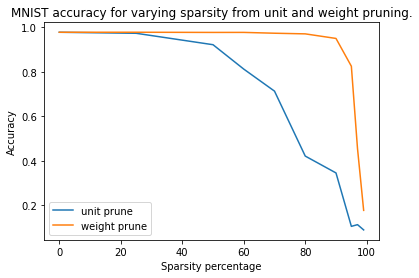

In [191]:
df = pd.DataFrame(index=pruning_factors, data={'unit prune': u_pruning_acc,
                                               'weight prune': w_pruning_acc})
ax = df.plot.line(title='MNIST accuracy for varying sparsity from unit and weight pruning.')
ax.set_xlabel("Sparsity percentage")
ax.set_ylabel("Accuracy")

## After fine-tuning

Next up I also wanted to see whether the pruned performance could be made any better by fine tuning the pruned models for another couple epochs.

In [ ]:
# fine tuning after weight pruning
model.set_weights(unpruned_weights)
w_pruning_acc = []
for pf in pruning_factors:
    model.prune(pf, mode='weight')
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer='adam', metrics=['accuracy'])
    model.fit(x_train, y_train, batch_size=512, epochs=100, 
              validation_split=0.2, callbacks=[es], verbose=0)
    test_scores = model.evaluate(x_test, y_test, verbose=0)
    w_pruning_acc.append(test_scores[1])  

pruned_weights = model.get_weights() 

In [193]:
# fine tuning after unit pruning
model.set_weights(unpruned_weights)
u_pruning_acc = []
for pf in pruning_factors:
    model.prune(pf, mode='unit')
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam', metrics=['accuracy'])
    model.fit(x_train, y_train, batch_size=512, epochs=100, 
              validation_split=0.2, callbacks=[es], verbose=0)
    test_scores = model.evaluate(x_test, y_test, verbose=0)
    u_pruning_acc.append(test_scores[1]) 

Epoch 00011: early stopping
Epoch 00023: early stopping
Epoch 00016: early stopping
Epoch 00019: early stopping
Epoch 00016: early stopping
Epoch 00011: early stopping
Epoch 00013: early stopping
Epoch 00017: early stopping
Epoch 00021: early stopping
Epoch 00068: early stopping


Text(0, 0.5, 'Accuracy')

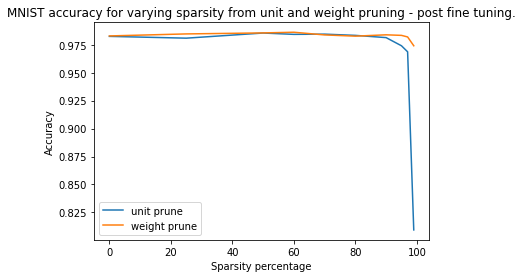

In [195]:
df = pd.DataFrame(index=pruning_factors, data={'unit prune': u_pruning_acc,
                                               'weight prune': w_pruning_acc})
ax = df.plot.line(title=('MNIST accuracy for varying sparsity from unit and weight pruning - post fine tuning.'))
ax.set_xlabel("Sparsity percentage")
ax.set_ylabel("Accuracy")

# Bonus - Improving inference time for sparse model

In the TF Docs I found that the linalg.matmul operation supports optimisations for sparse matrix multiplications. As the 99% sparse weight pruned model still performs quite well, going to have a play and see if we can speed up inference time exploiting these optimisations.

In [ ]:
model.prune(99, mode='unit')
for layer in model.prunable_layers:
    layer.sparse_compute = False
    layer.sparse_input = False
start_time = time.time()
for _ in range(50):
    test_scores = model.evaluate(x_train, y_train, verbose=0)
print(time.time()-start_time)

for layer in model.prunable_layers:
    layer.sparse_compute = True
    layer.sparse_input = True
start_time = time.time()
for _ in range(50):
    test_scores = model.evaluate(x_train, y_train, verbose=0)
print(time.time()-start_time)

751.0045845508575


# Conclusions

We observe in both unit and weight pruning cases that networks can be pruned up to 60% sparsity without significant drop in performance. This is due to the overparametrisation of the network meaning a lot of the parameters are redundant.

From both weight and unit pruning we can see that the performance doesn't degrade too significantly up till about 50% pruning. For unit pruning with > 50% sparsity the performance drops off quite significantly whilst for weight pruning it continue to degrade only slowly. This is a pretty interesting result and could be due to the fact that the representational capacity of the weight pruned sparse model continues to be reasonable in comparison to the unit pruned model even with high sparsity.



*   You can't assign directly to a tensor
*   Using a mask lets you stop backprop changing weights
*   

